In [1]:
%matplotlib inline
import os

from typing import List, Sequence, Any, Optional, Tuple

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Ensure figure text is consistent with LaTex text.
# matplotlib.rcParams["text.usetex"] = True
# matplotlib.rcParams["font.family"] = "serif"
# matplotlib.rcParams["font.size"] = "11"

## Utility Functions

In [2]:
def filter_by_values(data: pd.DataFrame, column: str, values: Sequence[Any]) -> pd.DataFrame:
    return data[data[column].isin(values)]

def average_over_seeds(data: pd.DataFrame) -> pd.DataFrame:
    averaged_data = data.groupby(["model", "task"], as_index=False).mean()
    averaged_data.drop("seed", axis="columns", inplace=True)
    return averaged_data

class PlotableSequence:
    __slots__ = ["label", "data", "plot_range"]

    def __init__(
        self,
        label: str,
        data: Sequence[Any],
        plot_range: Optional[Tuple[float, float]] = None
    ):
        self.label = label
        self.data = data
        self.plot_range = plot_range

def plot_bars_with_std(
    title: str,
    x: PlotableSequence,
    y: PlotableSequence,
    models: Sequence[str],
    std: PlotableSequence,
    ax: matplotlib.axes.Axes
) -> None:
    sns.barplot(
        x=x.data,
        y=y.data,
        hue=models,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(x.label)
    if x.plot_range is not None:
        ax.set_xlim(x.plot_range)
    ax.set_ylabel(y.label)
    if y.plot_range is not None:
        ax.set_ylim(y.plot_range)
    ax.tick_params(axis='x', labelrotation=30)
    ax.get_legend().set_title("")
    ax.get_yaxis().grid(linestyle="dashed")

    ax_twin_x = ax.twinx()

    sns.lineplot(
        x=x.data,
        y=std.data,
        marker="o",
        color="black",
        ax=ax_twin_x
    )
    ax_twin_x.set_ylabel(std.label)
    if x.plot_range is not None:
        ax_twin_x.set_xlim(x.plot_range)
    if std.plot_range is not None:
        ax_twin_x.set_ylim(std.plot_range)
    # ax_twin_x.get_yaxis().grid(linestyle="dashed")

def adjusted_r2_score(data: pd.DataFrame) -> None:
    ## Computing Adjusted R^2 ###
    # Based on: https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2

    dof_res = data["sample_size"] - data["n_params"]
    dof_tot = data["sample_size"] - 1
    return 1 - (1 - data["r2"]) * (dof_tot / dof_res)

def std_scaled_mae(data: pd.DataFrame) -> pd.Series:
    return data["mae"] / data["std"]

def relative_mae(data: pd.DataFrame, baseline_model: str) -> pd.Series:
    baseline = data[data["model"] == baseline_model]
    baseline_vals = baseline[["task", "mae"]].to_dict(orient="records")
    baseline_maes = {val["task"]: val["mae"] for val in baseline_vals}

    return results.apply(lambda r: r["mae"] / baseline_maes[r["task"]], axis=1)

## Vanilla Models

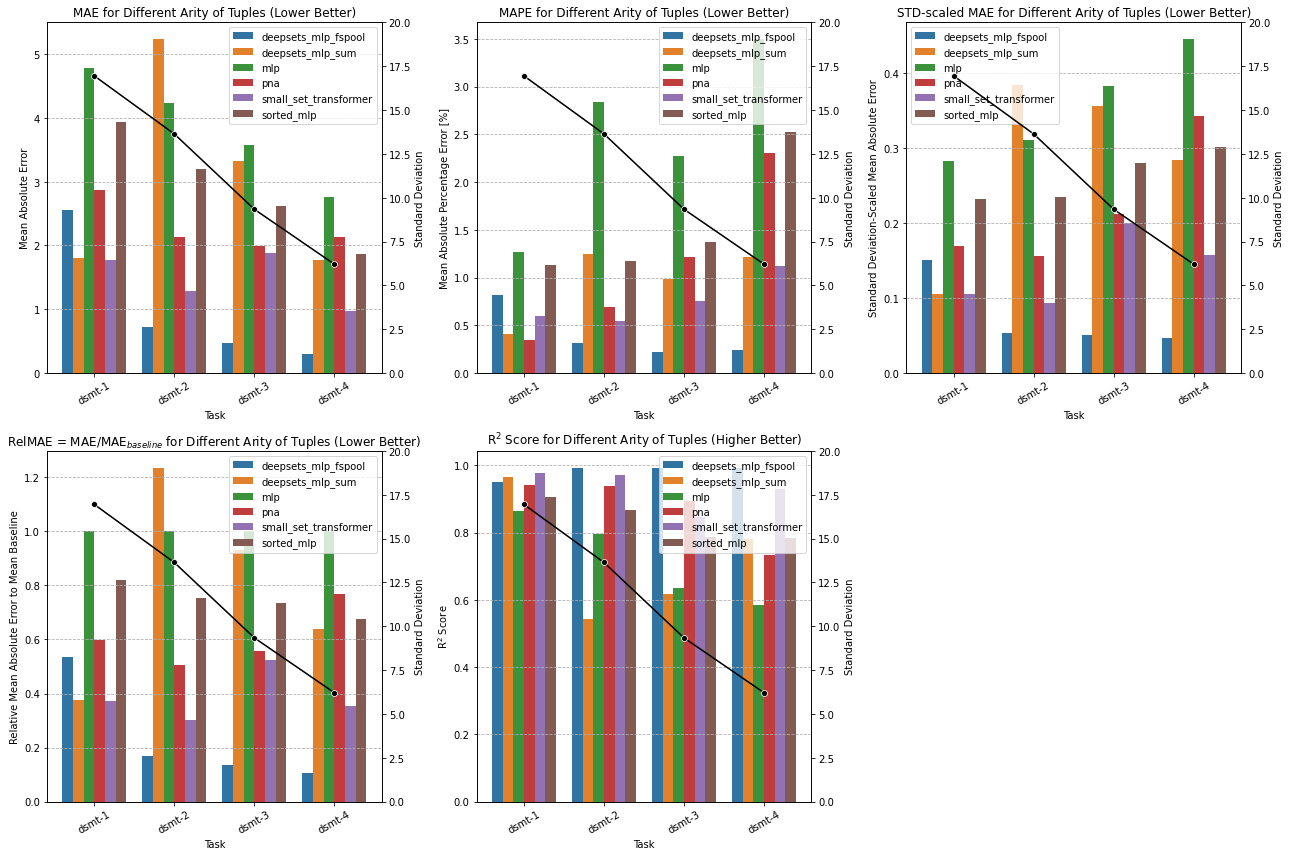

In [3]:
#################
# Preprocessing #
#################

MAX_ARITY = 4
ARITIES = [i + 1 for i in range(MAX_ARITY)]

results = pd.read_csv("desperate-student-m-tuple-results.csv")

results = results.rename(
    columns={
        "type": "model",
        "label": "task",
        "n_params": "n_params",
        "test_samples": "sample_size",
        "test_label_std": "std",
        "test_label_entropy": "entropy",
        "test_mae": "mae",
        "test_r2": "r2",
        "test_mape": "mape",
        "random_seed": "seed",
    }
)

results = filter_by_values(
    results,
    "task", 
    values=[f"desperate_student_{m}_tuple" for m in ARITIES]
)

results = filter_by_values(
    results,
    "model", 
    values=[
        "deepsets_mlp_sum",
        "deepsets_mlp_fspool",
        "sorted_mlp",
        "mlp",
        "pna",
        "small_set_transformer"
    ]
)

for m in ARITIES:
    results = results.replace(
        to_replace=f"desperate_student_{m}_tuple",
        value=f"dsmt-{m}"
    )

results = average_over_seeds(results)

results["adjusted_r2"] = adjusted_r2_score(results)
results["std_scaled_mae"] = std_scaled_mae(results)
results["rel_mae"] = relative_mae(results, baseline_model="mlp")

############
# Plotting #
############

_, axes = plt.subplots(2, 3, figsize=(18,12))

plot_bars_with_std(
    title="MAE for Different Arity of Tuples (Lower Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Mean Absolute Error", results["mae"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[0, 0]
)

plot_bars_with_std(
    title="MAPE for Different Arity of Tuples (Lower Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Mean Absolute Percentage Error [%]", results["mape"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[0, 1]
)

plot_bars_with_std(
    title="STD-scaled MAE for Different Arity of Tuples (Lower Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Standard Deviation-Scaled Mean Absolute Error", results["std_scaled_mae"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[0, 2]
)

plot_bars_with_std(
    title="RelMAE = MAE/MAE$_{baseline}$ for Different Arity of Tuples (Lower Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Relative Mean Absolute Error to Mean Baseline", results["rel_mae"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[1, 0]
)

plot_bars_with_std(
    title="R$^2$ Score for Different Arity of Tuples (Higher Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("R$^2$ Score", results["r2"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[1, 1]
)

# N.B.: Issue with degrees of freedom in the chosen models.
# plot_bars_with_std(
#     title="Adjusted R$^2$ Score for Different Arity of Tuples (Higher Better)",
#     x=PlotableSequence("Task", results["task"]),
#     y=PlotableSequence("R$^2$ Score", results["adjusted_r2"]),
#     models=results["model"],
#     std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
#     ax=axes[1][1]
# )

axes[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

## Optimized for Desperate Student 1 Tuple Task

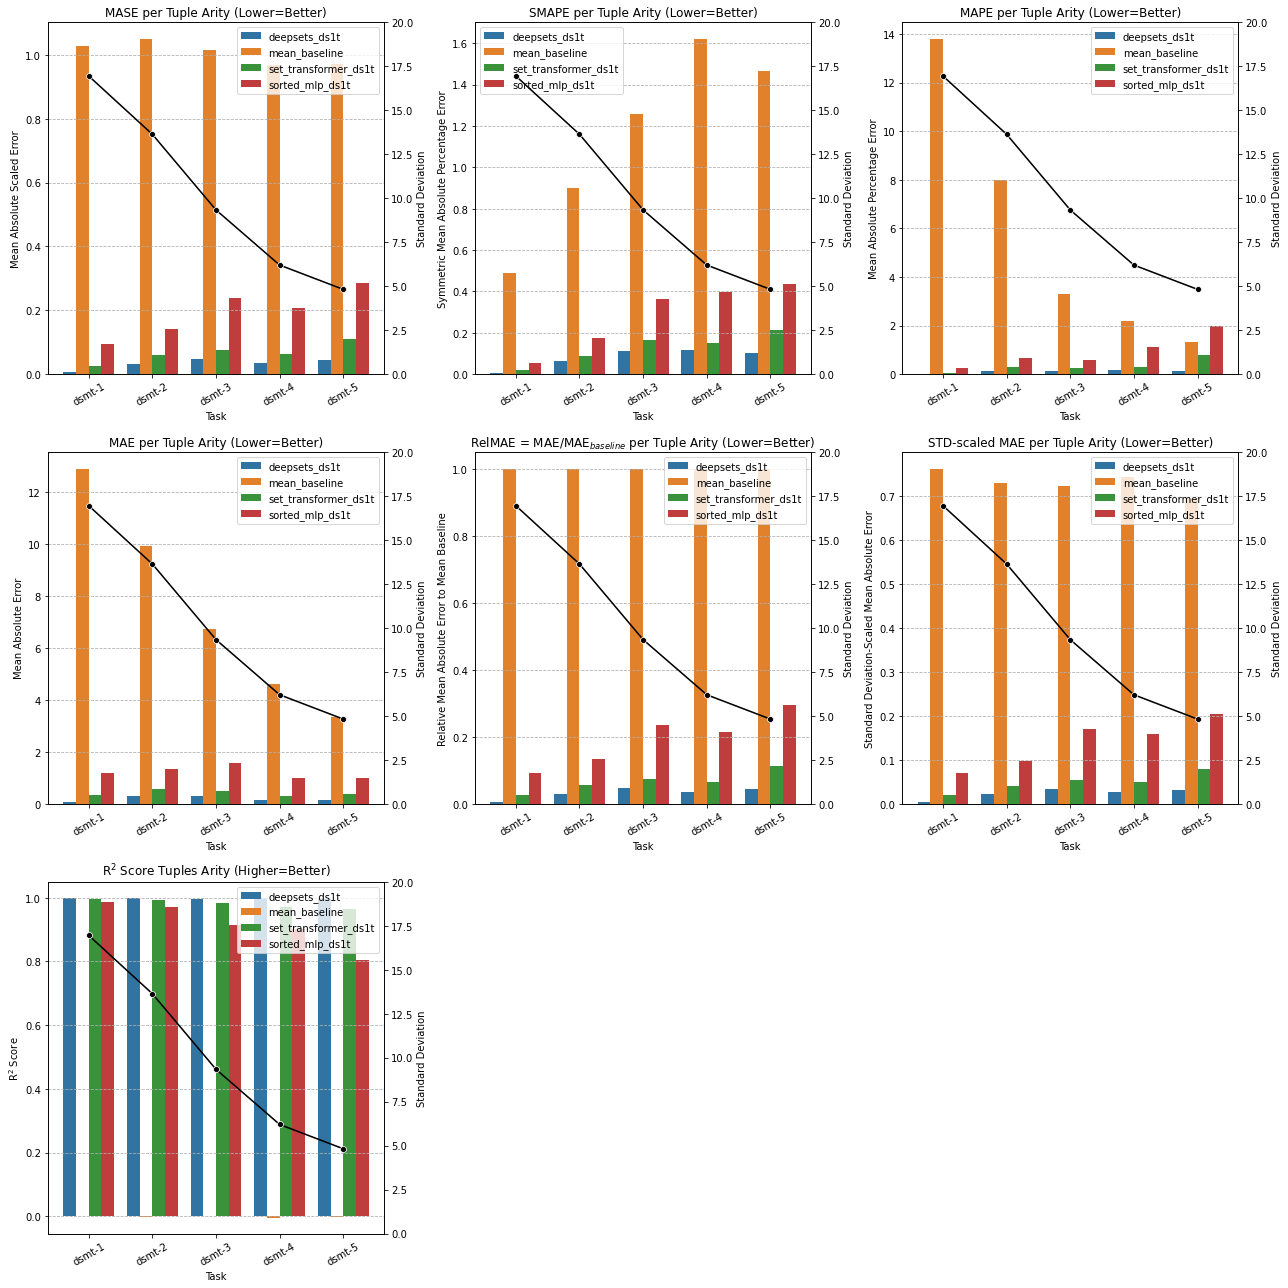

In [5]:
#################
# Preprocessing #
#################

MAX_ARITY = 5
ARITIES = [i + 1 for i in range(MAX_ARITY)]
MODELS = [
    "mean_baseline",
    "deepsets_ds1t",
    "sorted_mlp_ds1t",
    "set_transformer_ds1t"
]
exclude_baseline_plot = False

results = pd.read_csv("desperate-student-m-tuple-optim-results.csv")

results = results.rename(
    columns={
        "type": "model",
        "label": "task",
        "n_params": "n_params",
        "test_samples": "sample_size",
        "test_label_std": "std",
        "test_label_entropy": "entropy",
        "test_mae": "mae",
        "test_r2": "r2",
        "test_mape": "mape",
        "test_smape": "smape",
        "test_mase": "mase",
        "random_seed": "seed",
    }
)

results = filter_by_values(
    results,
    "task", 
    values=[f"desperate_student_{m}_tuple" for m in ARITIES]
)

results = filter_by_values(
    results,
    "model", 
    values=MODELS
)

for m in ARITIES:
    results = results.replace(
        to_replace=f"desperate_student_{m}_tuple",
        value=f"dsmt-{m}"
    )

results = average_over_seeds(results)

results["adjusted_r2"] = adjusted_r2_score(results)
results["std_scaled_mae"] = std_scaled_mae(results)
results["rel_mae"] = relative_mae(results, baseline_model="mean_baseline")

############
# Plotting #
############

# Exclude mean_baseline for plotting if required.
if exclude_baseline_plot:
    results = results[results["model"] != "mean_baseline"]

fig, axes = plt.subplots(3, 3, figsize=(18,18))
fig.set_facecolor("white")

plot_bars_with_std(
    title="MASE per Tuple Arity (Lower=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Mean Absolute Scaled Error", results["mase"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[0, 0]
)

plot_bars_with_std(
    title="SMAPE per Tuple Arity (Lower=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Symmetric Mean Absolute Percentage Error", results["smape"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[0, 1]
)

plot_bars_with_std(
    title="MAPE per Tuple Arity (Lower=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Mean Absolute Percentage Error", results["mape"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[0, 2]
)

plot_bars_with_std(
    title="MAE per Tuple Arity (Lower=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Mean Absolute Error", results["mae"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[1, 0]
)

plot_bars_with_std(
    title="RelMAE = MAE/MAE$_{baseline}$ per Tuple Arity (Lower=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Relative Mean Absolute Error to Mean Baseline", results["rel_mae"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[1, 1]
)

plot_bars_with_std(
    title="STD-scaled MAE per Tuple Arity (Lower=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("Standard Deviation-Scaled Mean Absolute Error", results["std_scaled_mae"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[1, 2]
)

plot_bars_with_std(
    title="R$^2$ Score Tuples Arity (Higher=Better)",
    x=PlotableSequence("Task", results["task"]),
    y=PlotableSequence("R$^2$ Score", results["r2"]),
    models=results["model"],
    std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
    ax=axes[2, 0]
)

# N.B.: Issue with degrees of freedom in the chosen models.
# plot_bars_with_std(
#     title="Adjusted R$^2$ Score for Different Arity of Tuples (Higher Better)",
#     x=PlotableSequence("Task", results["task"]),
#     y=PlotableSequence("R$^2$ Score", results["adjusted_r2"]),
#     models=results["model"],
#     std=PlotableSequence("Standard Deviation", results["std"], (0.0, 20.0)),
#     ax=axes[1][1]
# )

axes[2, 1].set_axis_off()
axes[2, 2].set_axis_off()

plt.tight_layout()
plt.show()